In [54]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import os
import re
import numpy as np
from numpy import mean, median
import seaborn as sns
import pandas as pd
import math
import sys
if "../" not in sys.path:
  sys.path.append("../")
matplotlib.style.use('ggplot')

In [55]:
# load files and add saved models data into one dictionary
rootdir = '../saved_models'
count = 0
all_data_dict = {'base': {},
                'newly_introduced': {}
                }

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        count += 1

        new_dict = np.load(os.path.join(subdir, file), allow_pickle='TRUE')
        
        source_id_str = str(int(new_dict.item()['config']['generic']['w_volte']*100)) + \
        str(int(new_dict.item()['config']['generic']['w_urllc']*100)) \
        + str(int(new_dict.item()['config']['generic']['w_video']*100))

        if (subdir == rootdir + '/base'):
            if source_id_str not in all_data_dict['base']:
                all_data_dict['base'][source_id_str] = {}
            
            all_data_dict['base'][source_id_str]['config'] = new_dict.item()['config']
            all_data_dict['base'][source_id_str]['rewards'] = new_dict.item()['rewards']
            
            
        elif (subdir == rootdir + '/non_accelerated'):
            if source_id_str not in all_data_dict['newly_introduced']:
                all_data_dict['newly_introduced'][source_id_str] = {}

            if 'non_accelerated' not in all_data_dict['newly_introduced'][source_id_str]:
                all_data_dict['newly_introduced'][source_id_str]['non_accelerated'] = {}
                
    
            all_data_dict['newly_introduced'][source_id_str]['non_accelerated']['config'] = new_dict.item()['config']
            all_data_dict['newly_introduced'][source_id_str]['non_accelerated']['rewards'] = new_dict.item()['rewards']

        elif (subdir == rootdir + '/accelerated'):

            result = re.search('_by_(.*)_', file)
            by_id_str = result.group(1)

            if source_id_str not in all_data_dict['newly_introduced']:
                all_data_dict['newly_introduced'][source_id_str] = {}
                
            if by_id_str not in all_data_dict['newly_introduced'][source_id_str]:
                all_data_dict['newly_introduced'][source_id_str][by_id_str] = {}
            
            
            all_data_dict['newly_introduced'][source_id_str][by_id_str]['config'] = new_dict.item()['config']
            all_data_dict['newly_introduced'][source_id_str][by_id_str]['rewards'] = new_dict.item()['rewards']
            all_data_dict['newly_introduced'][source_id_str][by_id_str]['config']['generic']['by_w_volte'] = int(by_id_str[0])/10
            all_data_dict['newly_introduced'][source_id_str][by_id_str]['config']['generic']['by_w_urllc'] = int(by_id_str[1])/10
            all_data_dict['newly_introduced'][source_id_str][by_id_str]['config']['generic']['by_w_video'] = int(by_id_str[2])/10

In [56]:
column_names1 = list(all_data_dict['base'].keys())
error_df = pd.DataFrame(columns = column_names1)
distance_df = pd.DataFrame(columns = column_names1)

column_names2 = ['w_volte', 'w_urllc', 'w_video', 'error', 'distance', 'by_w_volte', 'by_w_urllc', 'by_w_video']
generic_df = pd.DataFrame(columns = column_names2)

weight_distance = []
reward_error = []
positive_reward_error = []
weight_introduced = []
weight_by = []
count = 0

In [57]:
for weight_comb in all_data_dict['newly_introduced']:
    generic_row_holder = []
    error_row_holder = []
    distance_row_holder = []
    for model, v in sorted(all_data_dict['newly_introduced'][weight_comb].items()):
        if model == 'non_accelerated':
            continue

        error =  max(all_data_dict['newly_introduced'][weight_comb]['non_accelerated']['rewards']['episodes']- \
            max(all_data_dict['newly_introduced'][weight_comb][model]['rewards']['episodes']) )
        
        dist = np.linalg.norm(np.array([int(weight_comb[0])/10, int(weight_comb[1])/10, int(weight_comb[2])/10])\
                      - np.array([int(model[0])/10, int(model[1])/10, int(model[2])/10]))
        
        
        reward_error.append(error)
        weight_distance.append(dist)
        error_row_holder.append(error)
        distance_row_holder.append(dist)
        weight_introduced.append(weight_comb)
        weight_by.append(model)
        
        w_volte = all_data_dict['newly_introduced'][weight_comb][model]['config']['generic']['w_volte']
        w_urllc = all_data_dict['newly_introduced'][weight_comb][model]['config']['generic']['w_urllc']
        w_video = all_data_dict['newly_introduced'][weight_comb][model]['config']['generic']['w_video']

        by_w_volte = all_data_dict['newly_introduced'][weight_comb][model]['config']['generic']['by_w_volte']
        by_w_urllc = all_data_dict['newly_introduced'][weight_comb][model]['config']['generic']['by_w_urllc']
        by_w_video = all_data_dict['newly_introduced'][weight_comb][model]['config']['generic']['by_w_video']

        generic_row_holder = [w_volte, w_urllc, w_video, error, dist, by_w_volte, by_w_urllc, by_w_video]
        generic_df.loc[len(generic_df.index)] = generic_row_holder
        
        if error > 0:
            positive_reward_error.append([weight_comb, model])
        count += 1

In [58]:
generic_df.head()

,w_volte,w_urllc,w_video,error,distance,by_w_volte,by_w_urllc,by_w_video
0,0.3,0.6,0.1,1.911888,0.300000,0.1,0.1,0.8
1,0.3,0.6,0.1,20.316709,0.300000,0.1,0.2,0.7
2,0.3,0.6,0.1,10.261847,0.360555,0.1,0.3,0.6
3,0.3,0.6,0.1,10.471273,0.489898,0.1,0.4,0.4
4,0.3,0.6,0.1,9.926252,0.458258,0.1,0.4,0.5


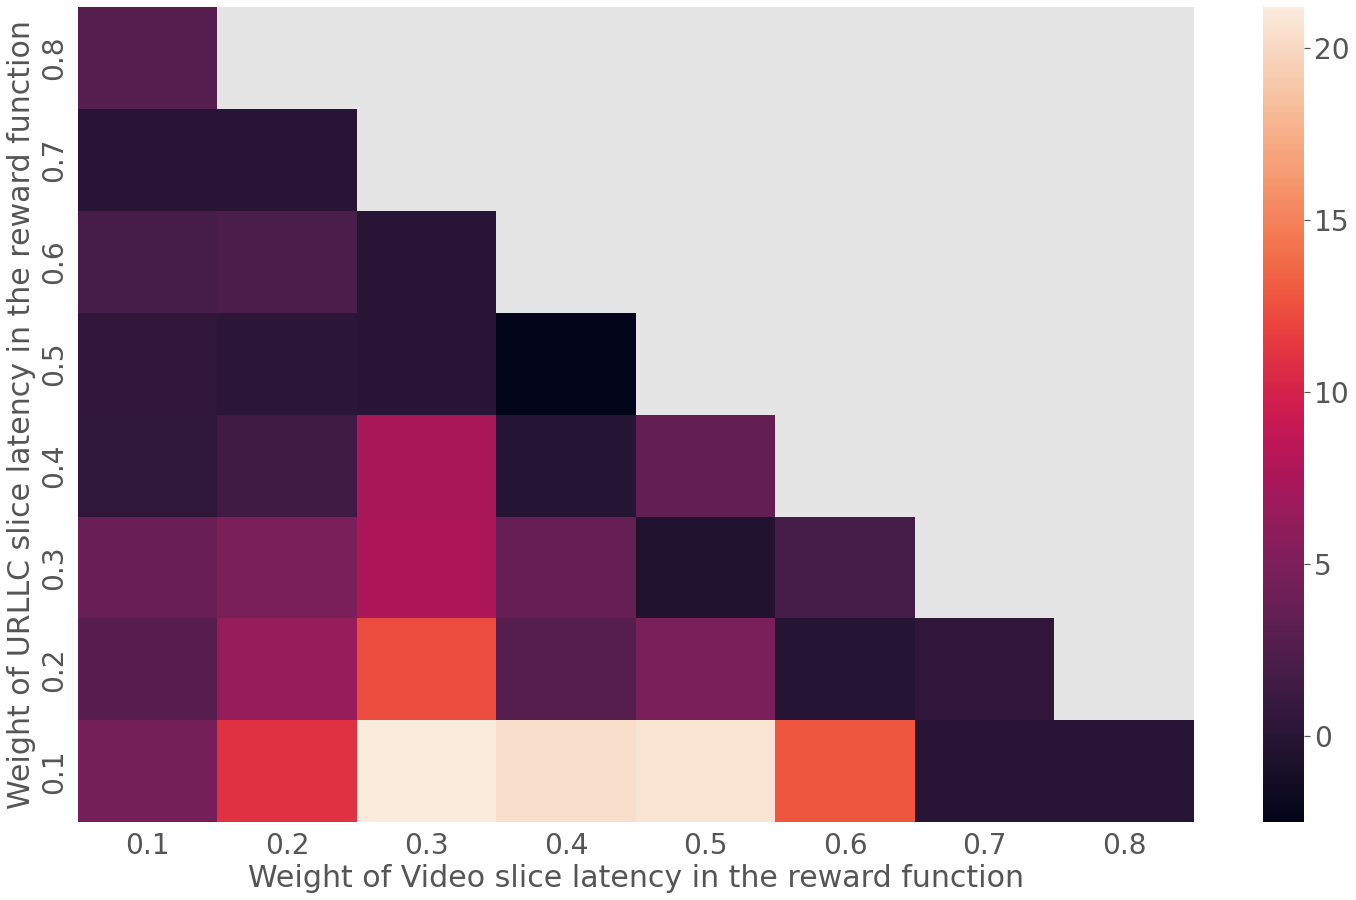

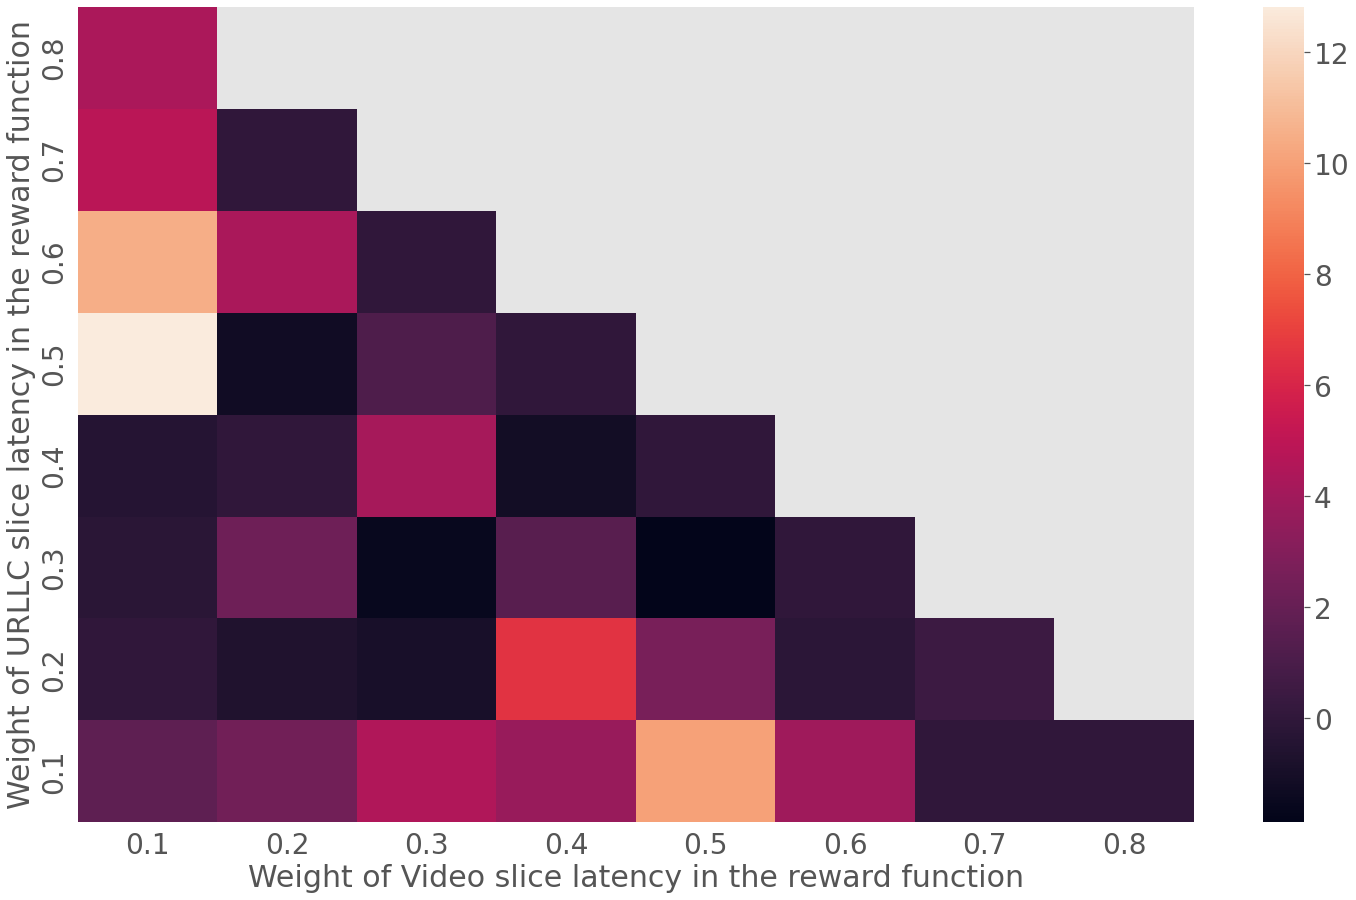

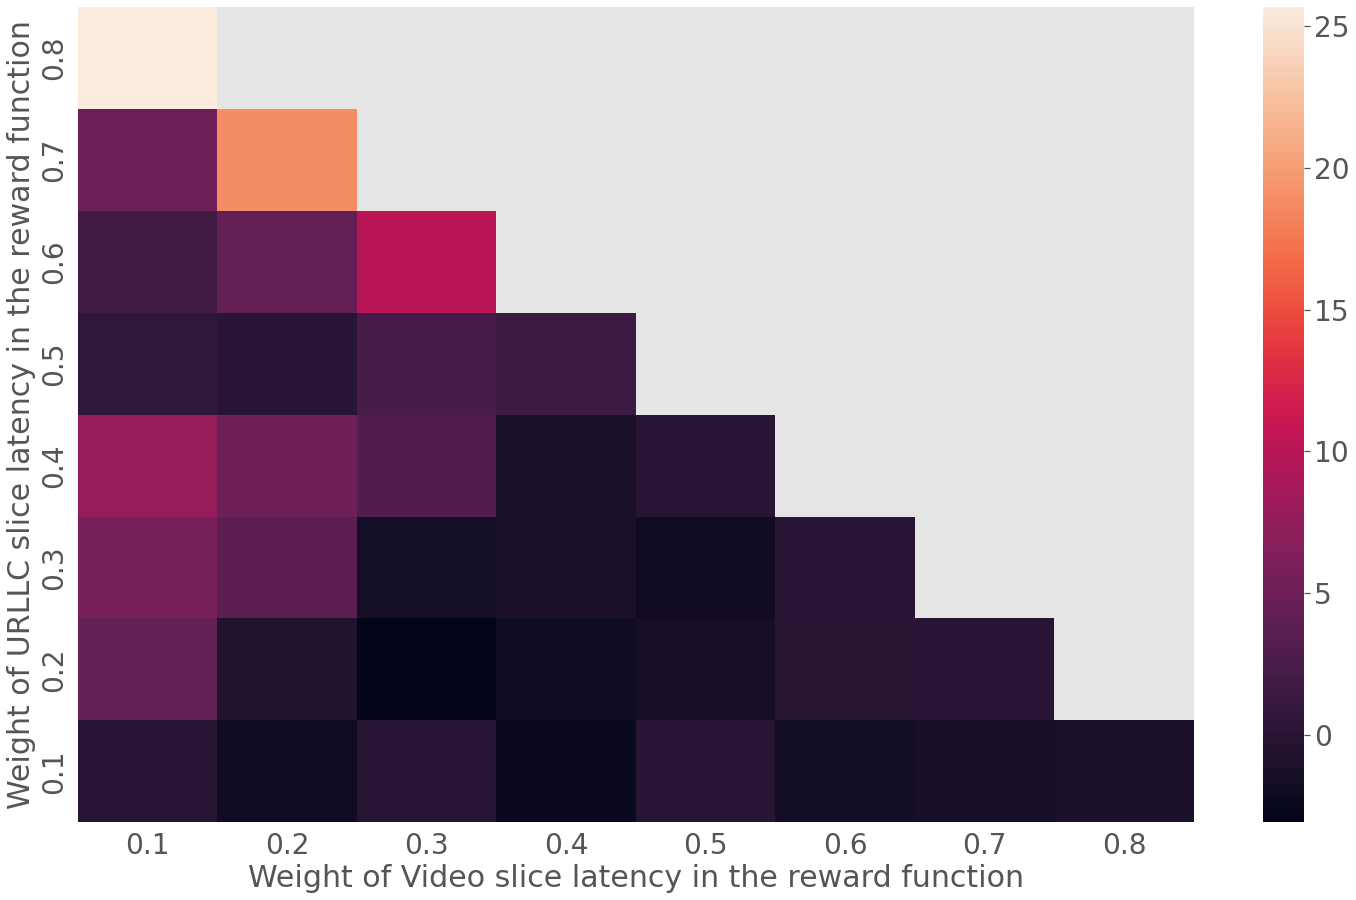

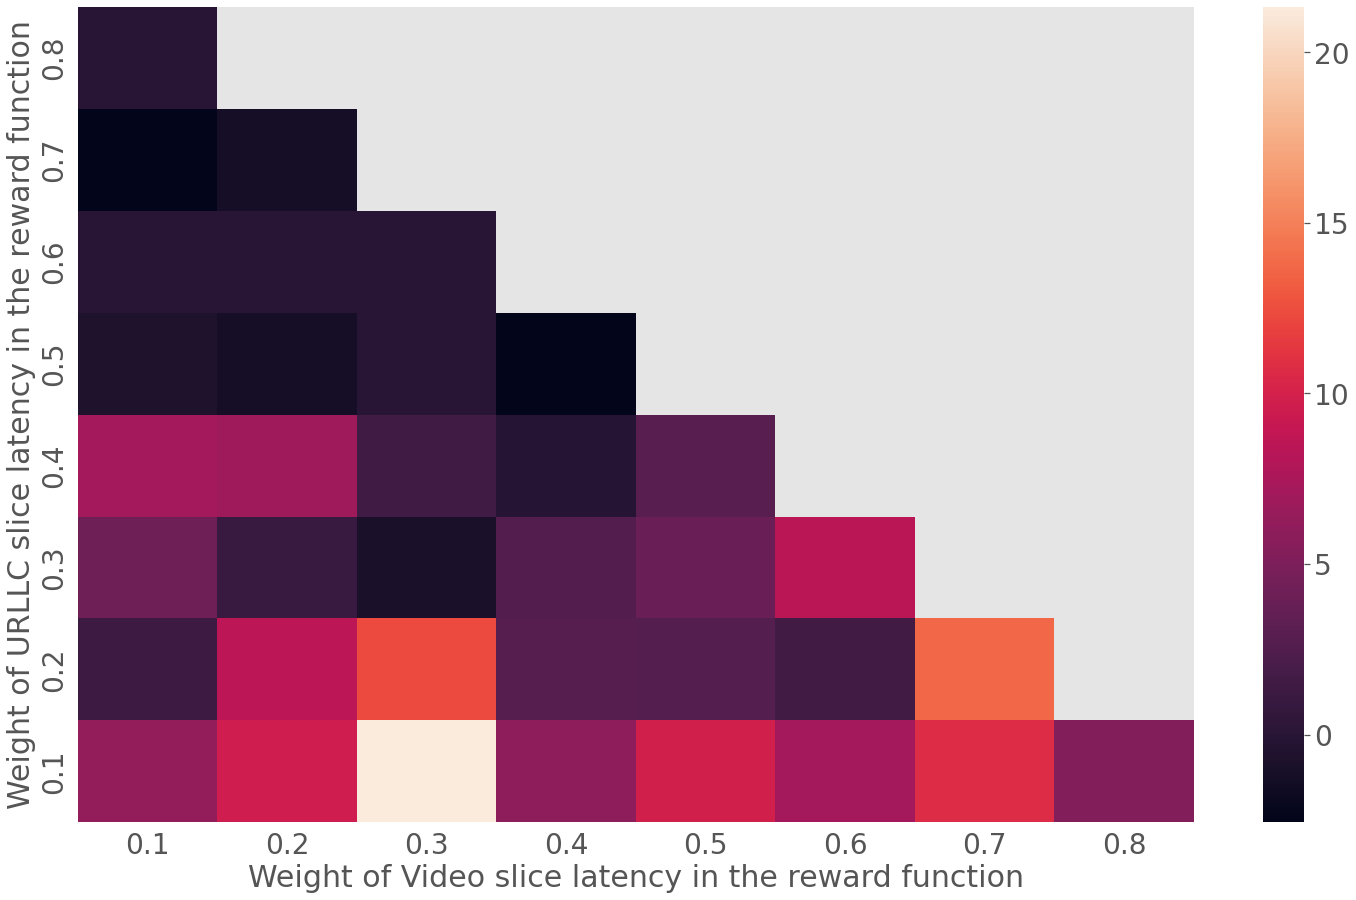

In [59]:
side = 'w_urllc'
top = 'w_video'

for saved_model in all_data_dict['base']:
    if (saved_model != '101080' and saved_model != '105040' and saved_model != '107020' and saved_model != '108010'):
        continue
    
    saved_model_of_interest_w_volte = all_data_dict['base'][saved_model]['config']['generic']['w_volte']
    saved_model_of_interest_w_urllc = all_data_dict['base'][saved_model]['config']['generic']['w_urllc']
    saved_model_of_interest_w_video = all_data_dict['base'][saved_model]['config']['generic']['w_video']

    
    temp_df = generic_df[[side, top, 'error']][(generic_df['by_w_volte'] == saved_model_of_interest_w_volte ) & \
                                              (generic_df['by_w_urllc'] == saved_model_of_interest_w_urllc) &  \
                                              (generic_df['by_w_video'] == saved_model_of_interest_w_video)]
    temp_df = temp_df.sort_values(by = [side, top], ascending = [True, True])
    temp_df = temp_df.reset_index(drop=True)

    temp_temp_df = pd.DataFrame(columns = np.sort(np.array(temp_df[top].unique())) )

    for side_item in np.sort(np.array(temp_df[side].unique()))[::-1] :
        temp_temp_row = []
        for top_item in np.sort(np.array(temp_df[top].unique())):
            if (not temp_df[ (temp_df[side]==side_item) & (temp_df[top]==top_item) ]['error'].empty):
                temp_temp_row.append(\
                                    temp_df[(temp_df[side]==side_item) \
                                            & (temp_df[top]==top_item)]['error'].reset_index(drop=True)[0])

            else:
                temp_temp_row.append(math.nan)

        temp_temp_df.loc[side_item] = temp_temp_row

    fig, ax = plt.subplots(figsize=(25,15))

    p = sns.heatmap(ax=ax, data=temp_temp_df)
    cax = p.figure.axes[-1]
    cax.tick_params(labelsize=28)
    p.set(xlabel=top,ylabel=side)

    plt.yticks(fontsize=28)
    plt.xticks(fontsize=28)
    plt.xlabel("Weight of Video slice latency in the reward function", fontsize=30)
    plt.ylabel("Weight of URLLC slice latency in the reward function", fontsize=30)

    if (saved_model == '101080'):
        plt.savefig('fig6-1.png', dpi=300, bbox_inches='tight')
    elif (saved_model == '105040'):
        plt.savefig('fig6-2.png', dpi=300, bbox_inches='tight')
    elif (saved_model == '107020'):
        plt.savefig('fig6-3.png', dpi=300, bbox_inches='tight')
    elif (saved_model == '108010'):
        plt.savefig('fig6-4.png', dpi=300, bbox_inches='tight')

In [60]:
temp_df.head()

,w_urllc,w_video,error
0,0.1,0.1,6.224618
1,0.1,0.2,9.623791
2,0.1,0.3,21.330462
3,0.1,0.4,5.965792
4,0.1,0.5,9.831001


In [61]:
error_df = pd.read_pickle('error_data.pkl')

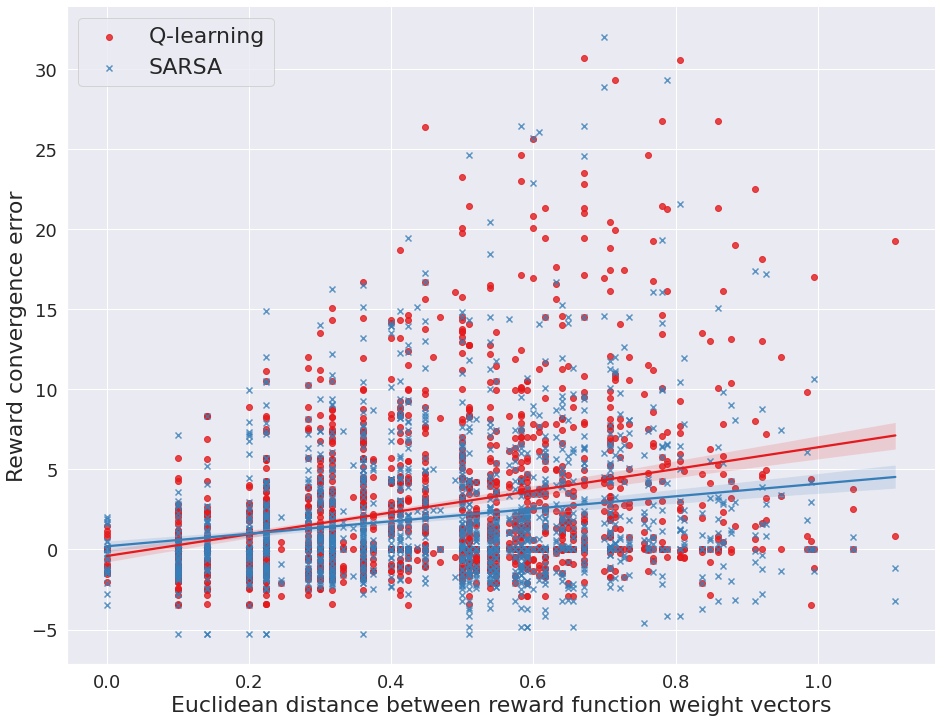

In [62]:
sns.set(rc={'figure.figsize':(8,6)})
p = sns.lmplot(x='distance', y='error',  legend=False,hue='algo',
           data=error_df, height=10, aspect=1.3, markers=["o", "x"], palette="Set1", fit_reg=True,  scatter=True)
plt.legend(loc='upper left', fontsize=22)

plt.ylabel("Reward convergence error", fontsize=22)
plt.xlabel("Euclidean distance between reward function weight vectors", fontsize=22)

plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.savefig('fig5.png',dpi=300, bbox_inches='tight')

In [63]:
# load files and add saved models data into one dictionary

rootdir = '../saved_models_all'
count = 0
all_data_dict = {'base': {},
                'newly_introduced': {}
                }


for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        count += 1
        new_dict = np.load(os.path.join(subdir, file), allow_pickle='TRUE')
        source_id_str = str(int(new_dict.item()['config']['generic']['w_volte']*100)) + \
        str(int(new_dict.item()['config']['generic']['w_urllc']*100)) \
        + str(int(new_dict.item()['config']['generic']['w_video']*100))

        if (subdir == '../saved_models_all/base'):

        
            if source_id_str not in all_data_dict['base']:
                all_data_dict['base'][source_id_str] = {}
            
            all_data_dict['base'][source_id_str]['config'] = new_dict.item()['config']
            all_data_dict['base'][source_id_str]['rewards'] = new_dict.item()['rewards']
            
        elif (subdir == '../saved_models_all/non_accelerated'):

            if source_id_str not in all_data_dict['newly_introduced']:
                all_data_dict['newly_introduced'][source_id_str] = {}

            if 'non_accelerated' not in all_data_dict['newly_introduced'][source_id_str]:
                all_data_dict['newly_introduced'][source_id_str]['non_accelerated'] = {}
                
    
            all_data_dict['newly_introduced'][source_id_str]['non_accelerated']['config'] = new_dict.item()['config']
            all_data_dict['newly_introduced'][source_id_str]['non_accelerated']['rewards'] = new_dict.item()['rewards']

        elif (subdir == '../saved_models_all/accelerated'):

            result = re.search('_by_(.*)_', file)
            by_id_str = result.group(1)
            if source_id_str not in all_data_dict['newly_introduced']:
                all_data_dict['newly_introduced'][source_id_str] = {}
                
            if by_id_str not in all_data_dict['newly_introduced'][source_id_str]:
                all_data_dict['newly_introduced'][source_id_str][by_id_str] = {}
            
            
            all_data_dict['newly_introduced'][source_id_str][by_id_str]['config'] = new_dict.item()['config']
            all_data_dict['newly_introduced'][source_id_str][by_id_str]['rewards'] = new_dict.item()['rewards']

Communlative Reward over 100 learning steps 0.5 0.4 0.1


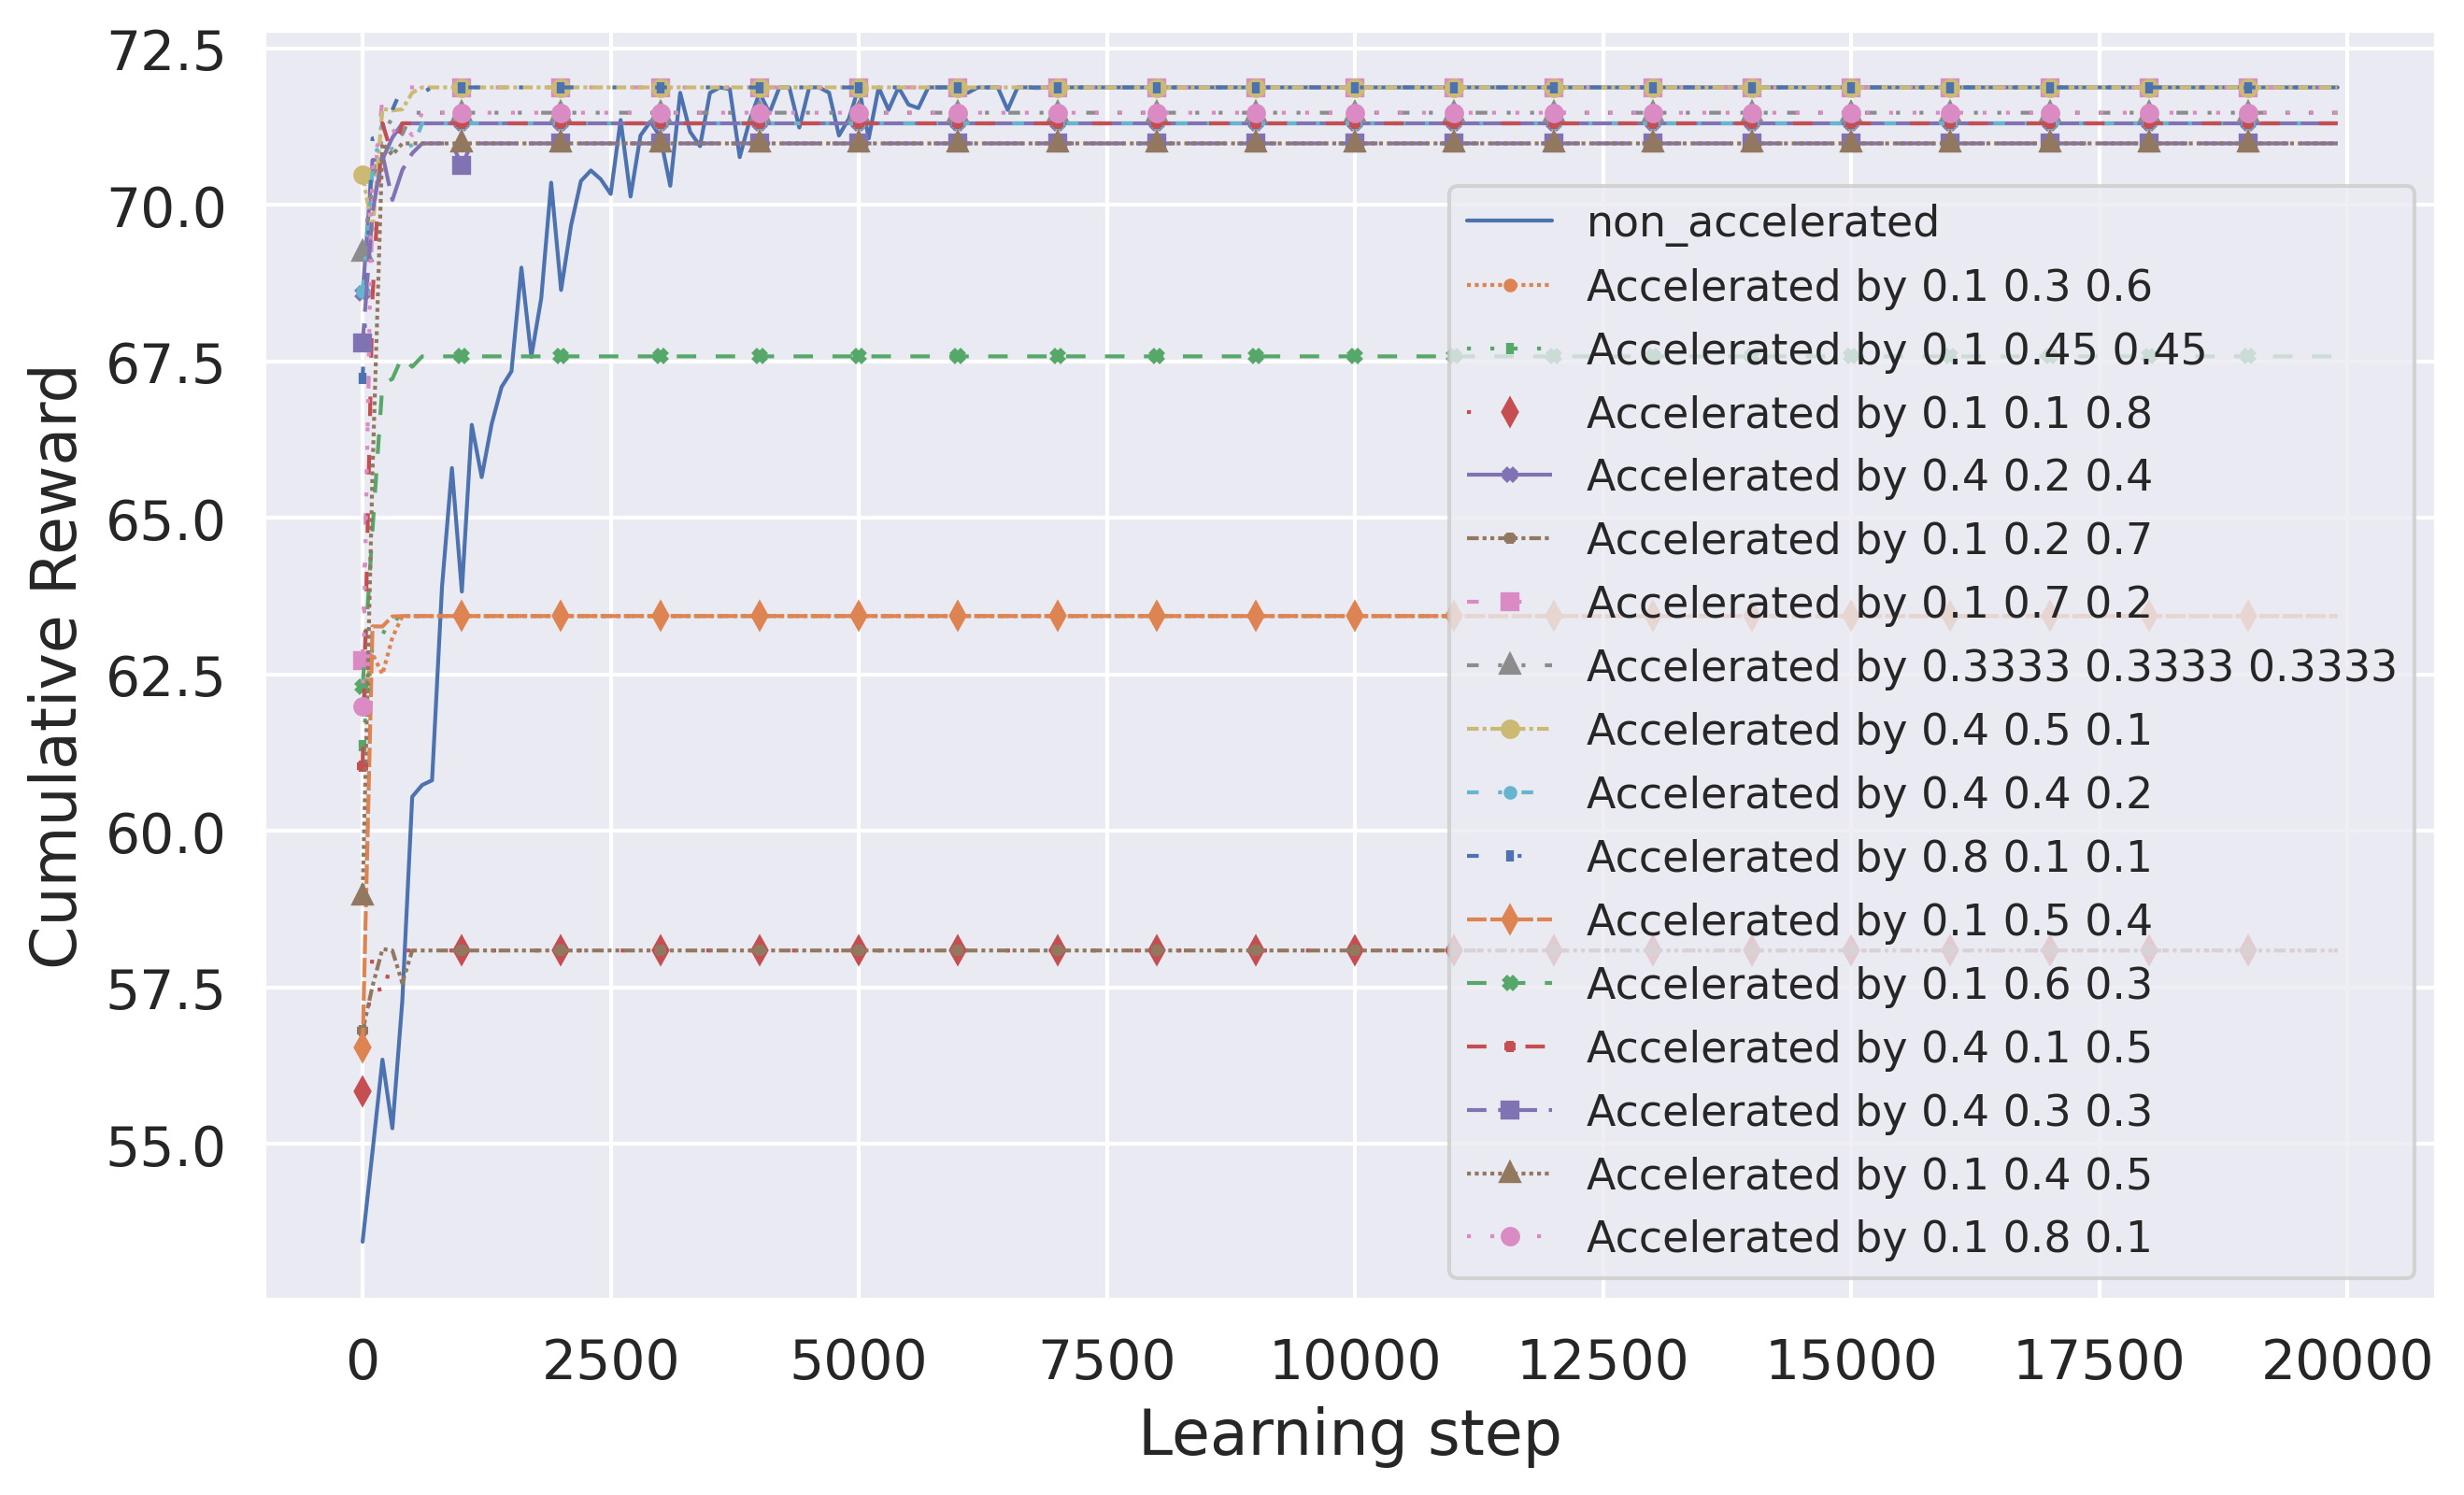

Communlative Reward over 100 learning steps 0.25 0.7 0.05


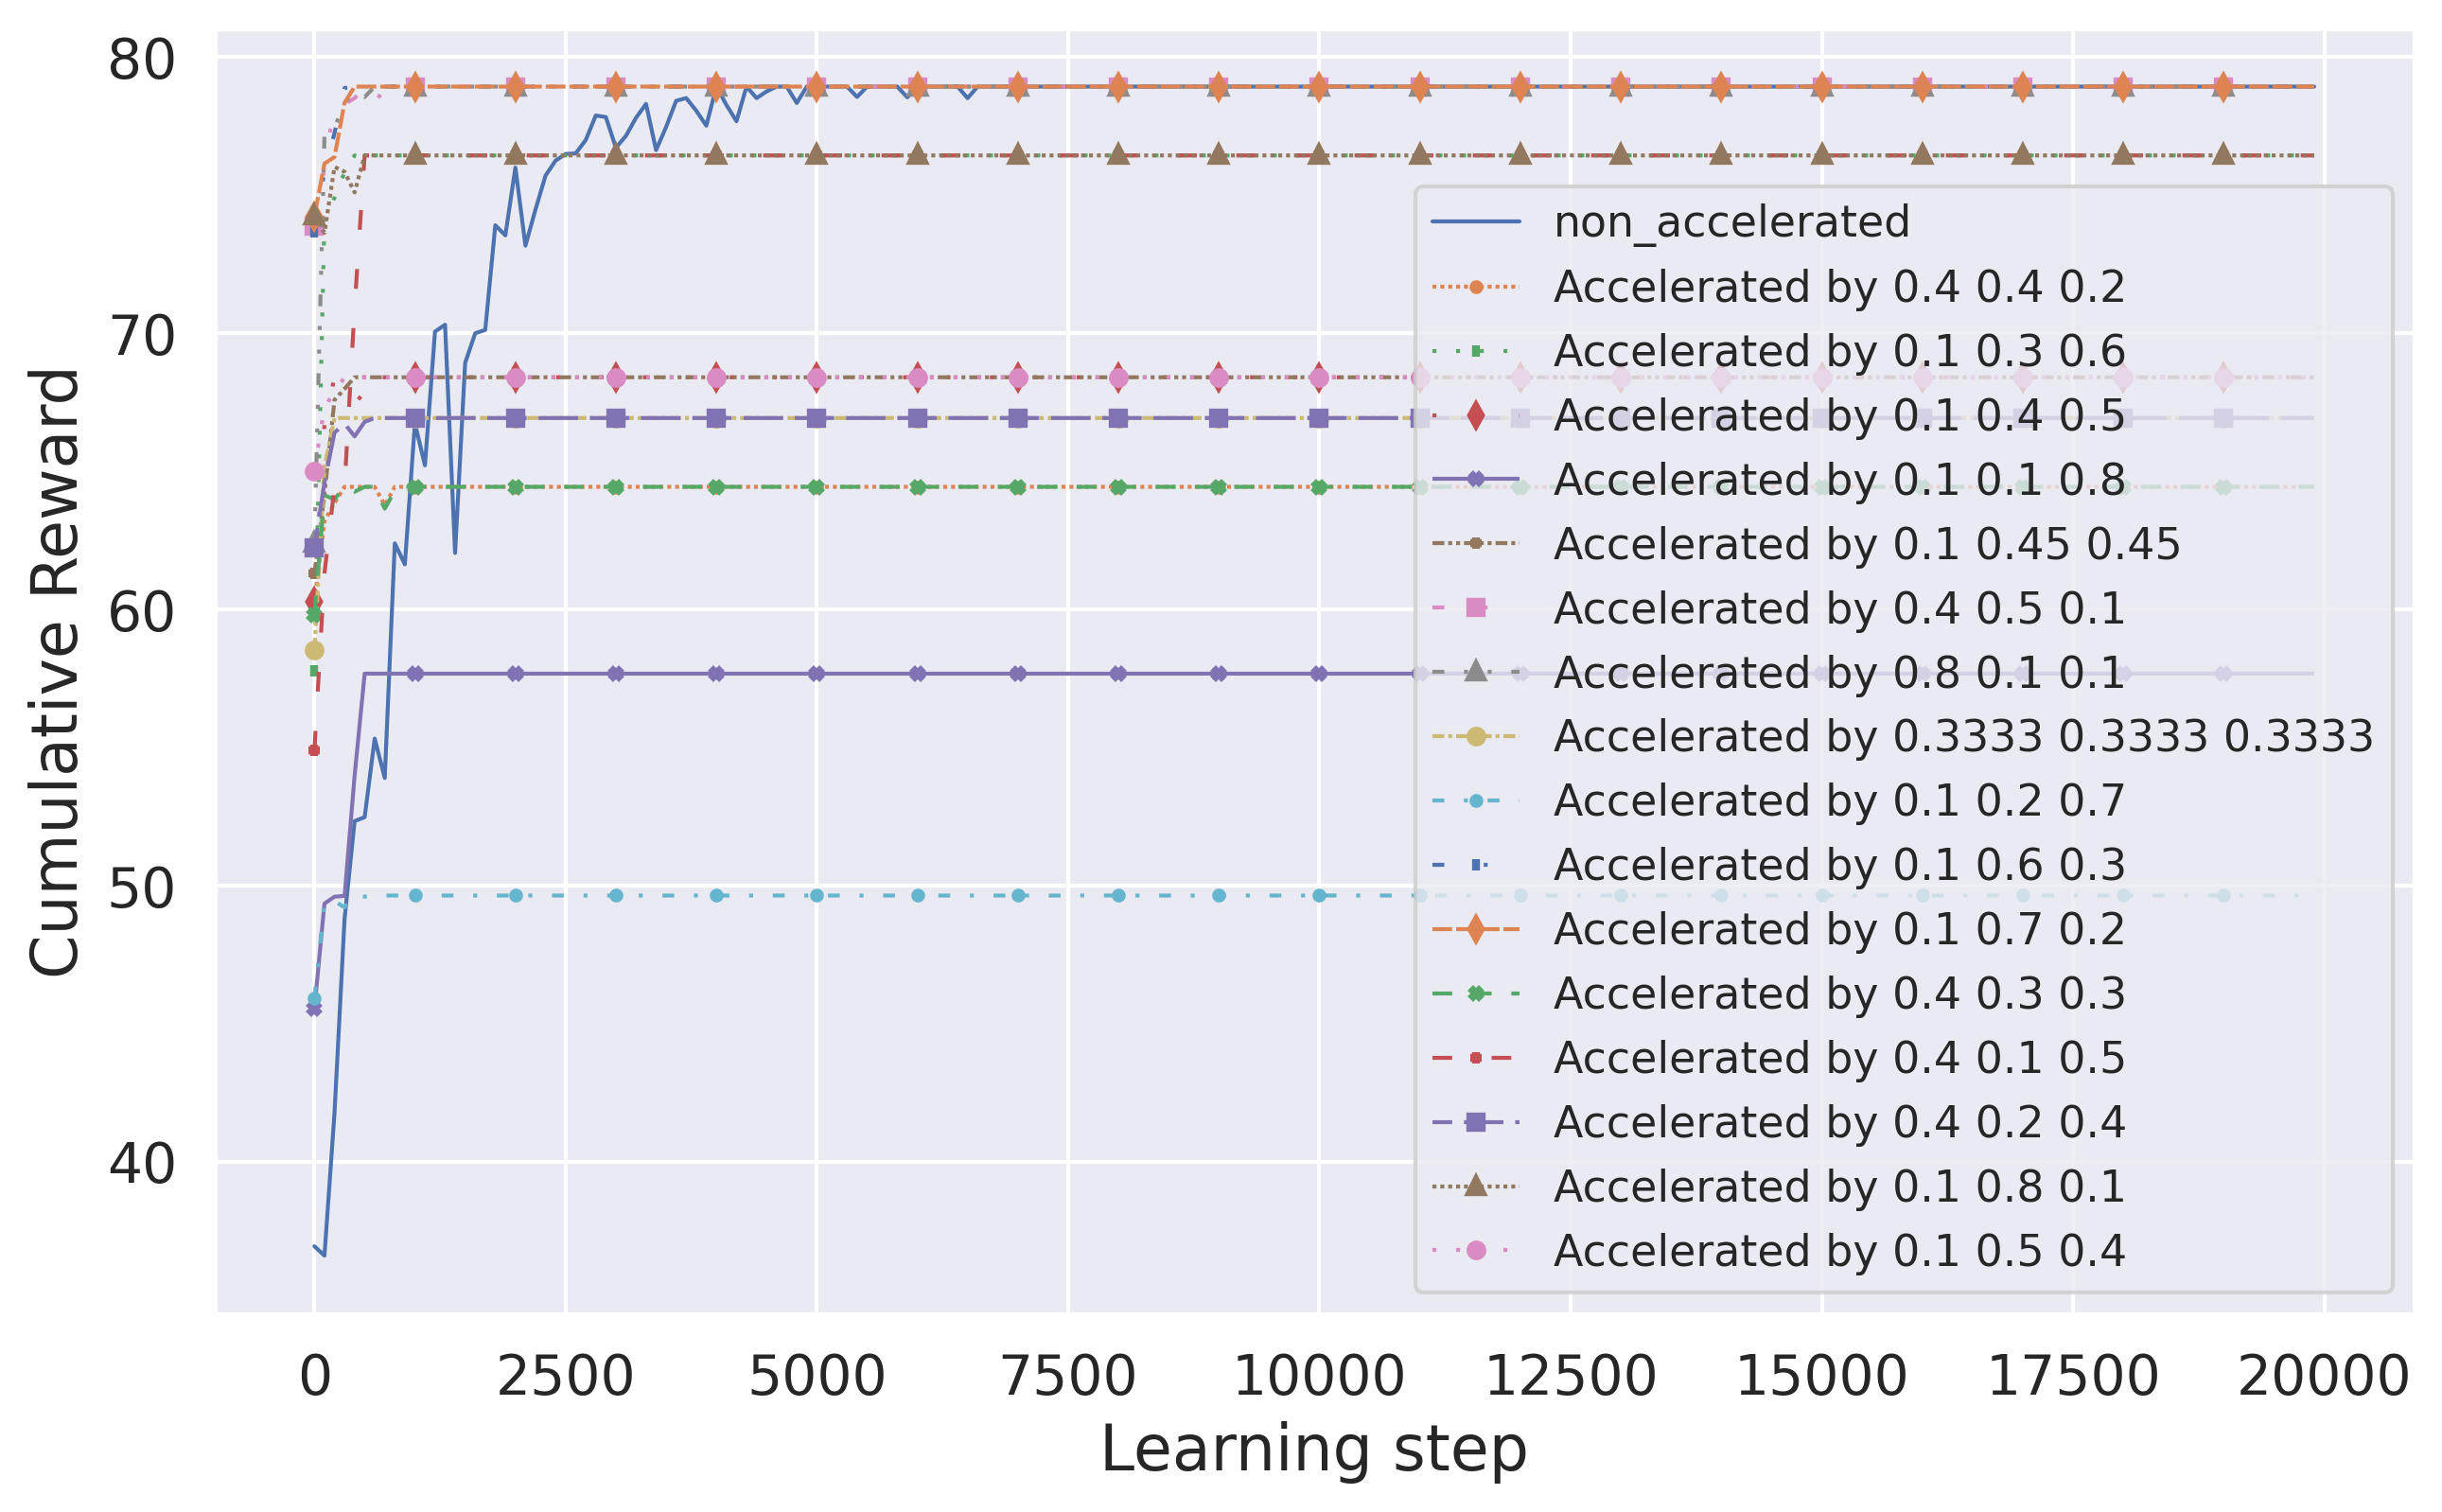

Communlative Reward over 100 learning steps 0.15 0.8 0.05


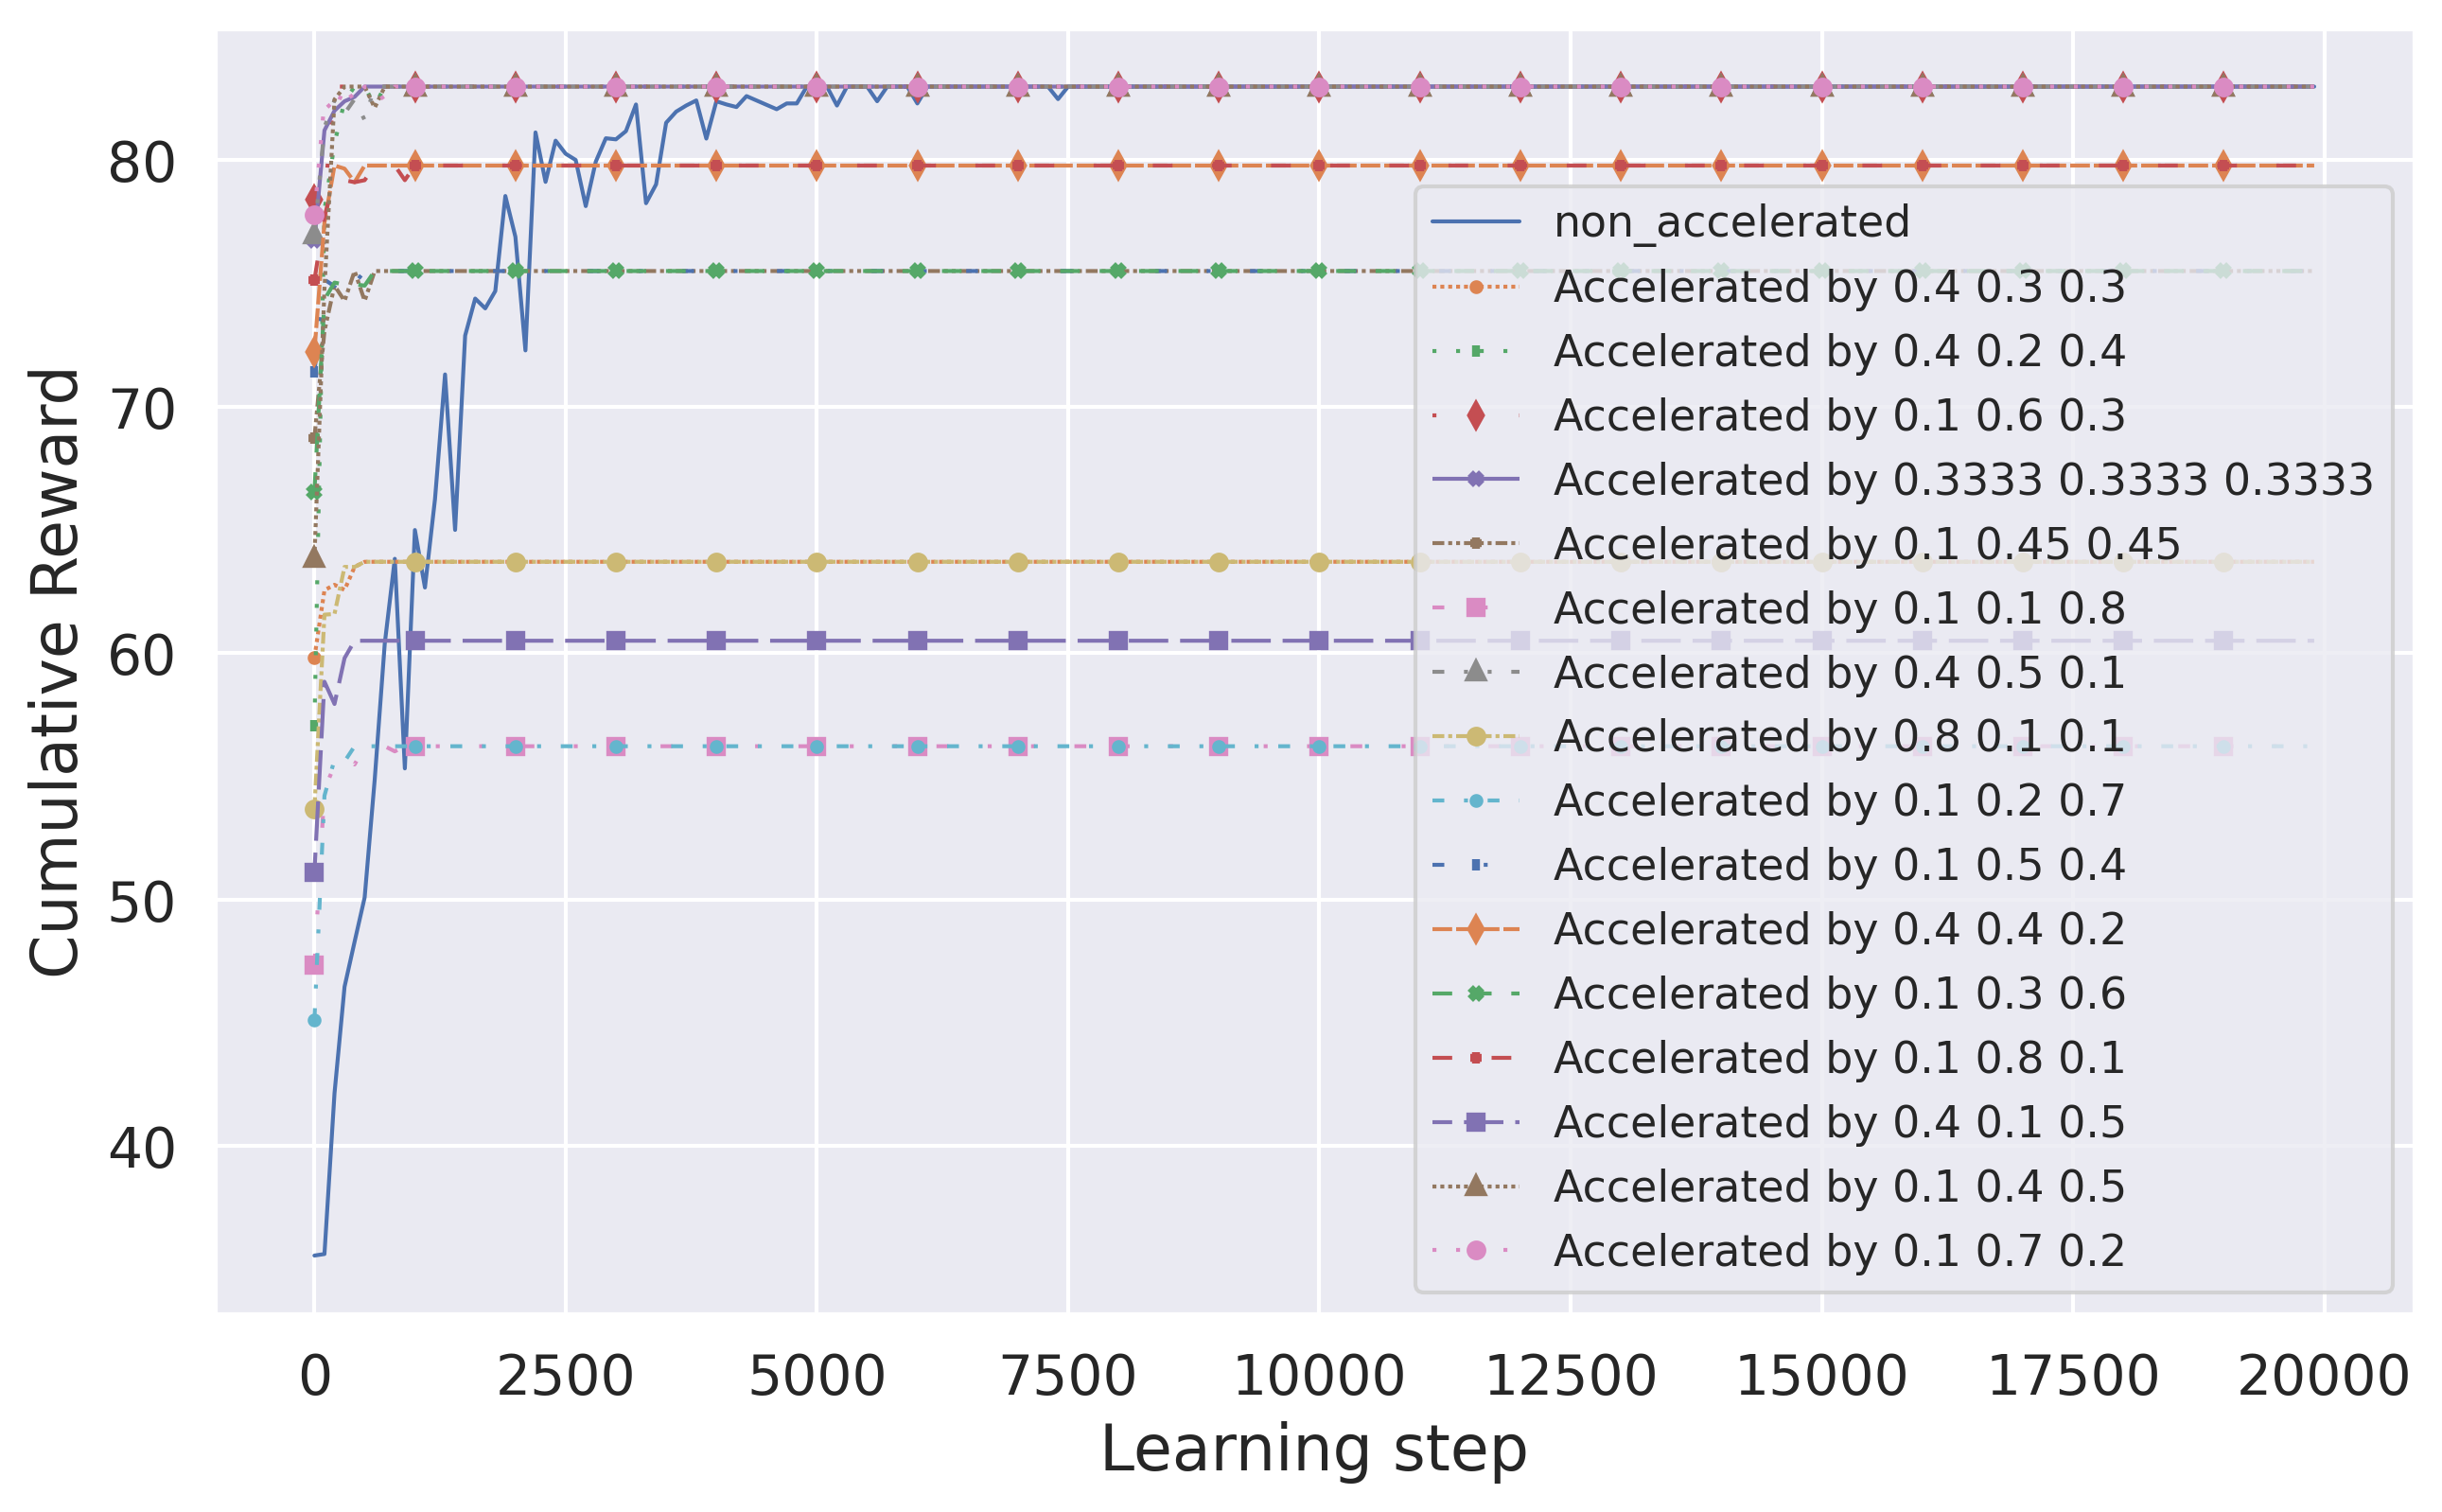

Communlative Reward over 100 learning steps 0.1 0.55 0.35


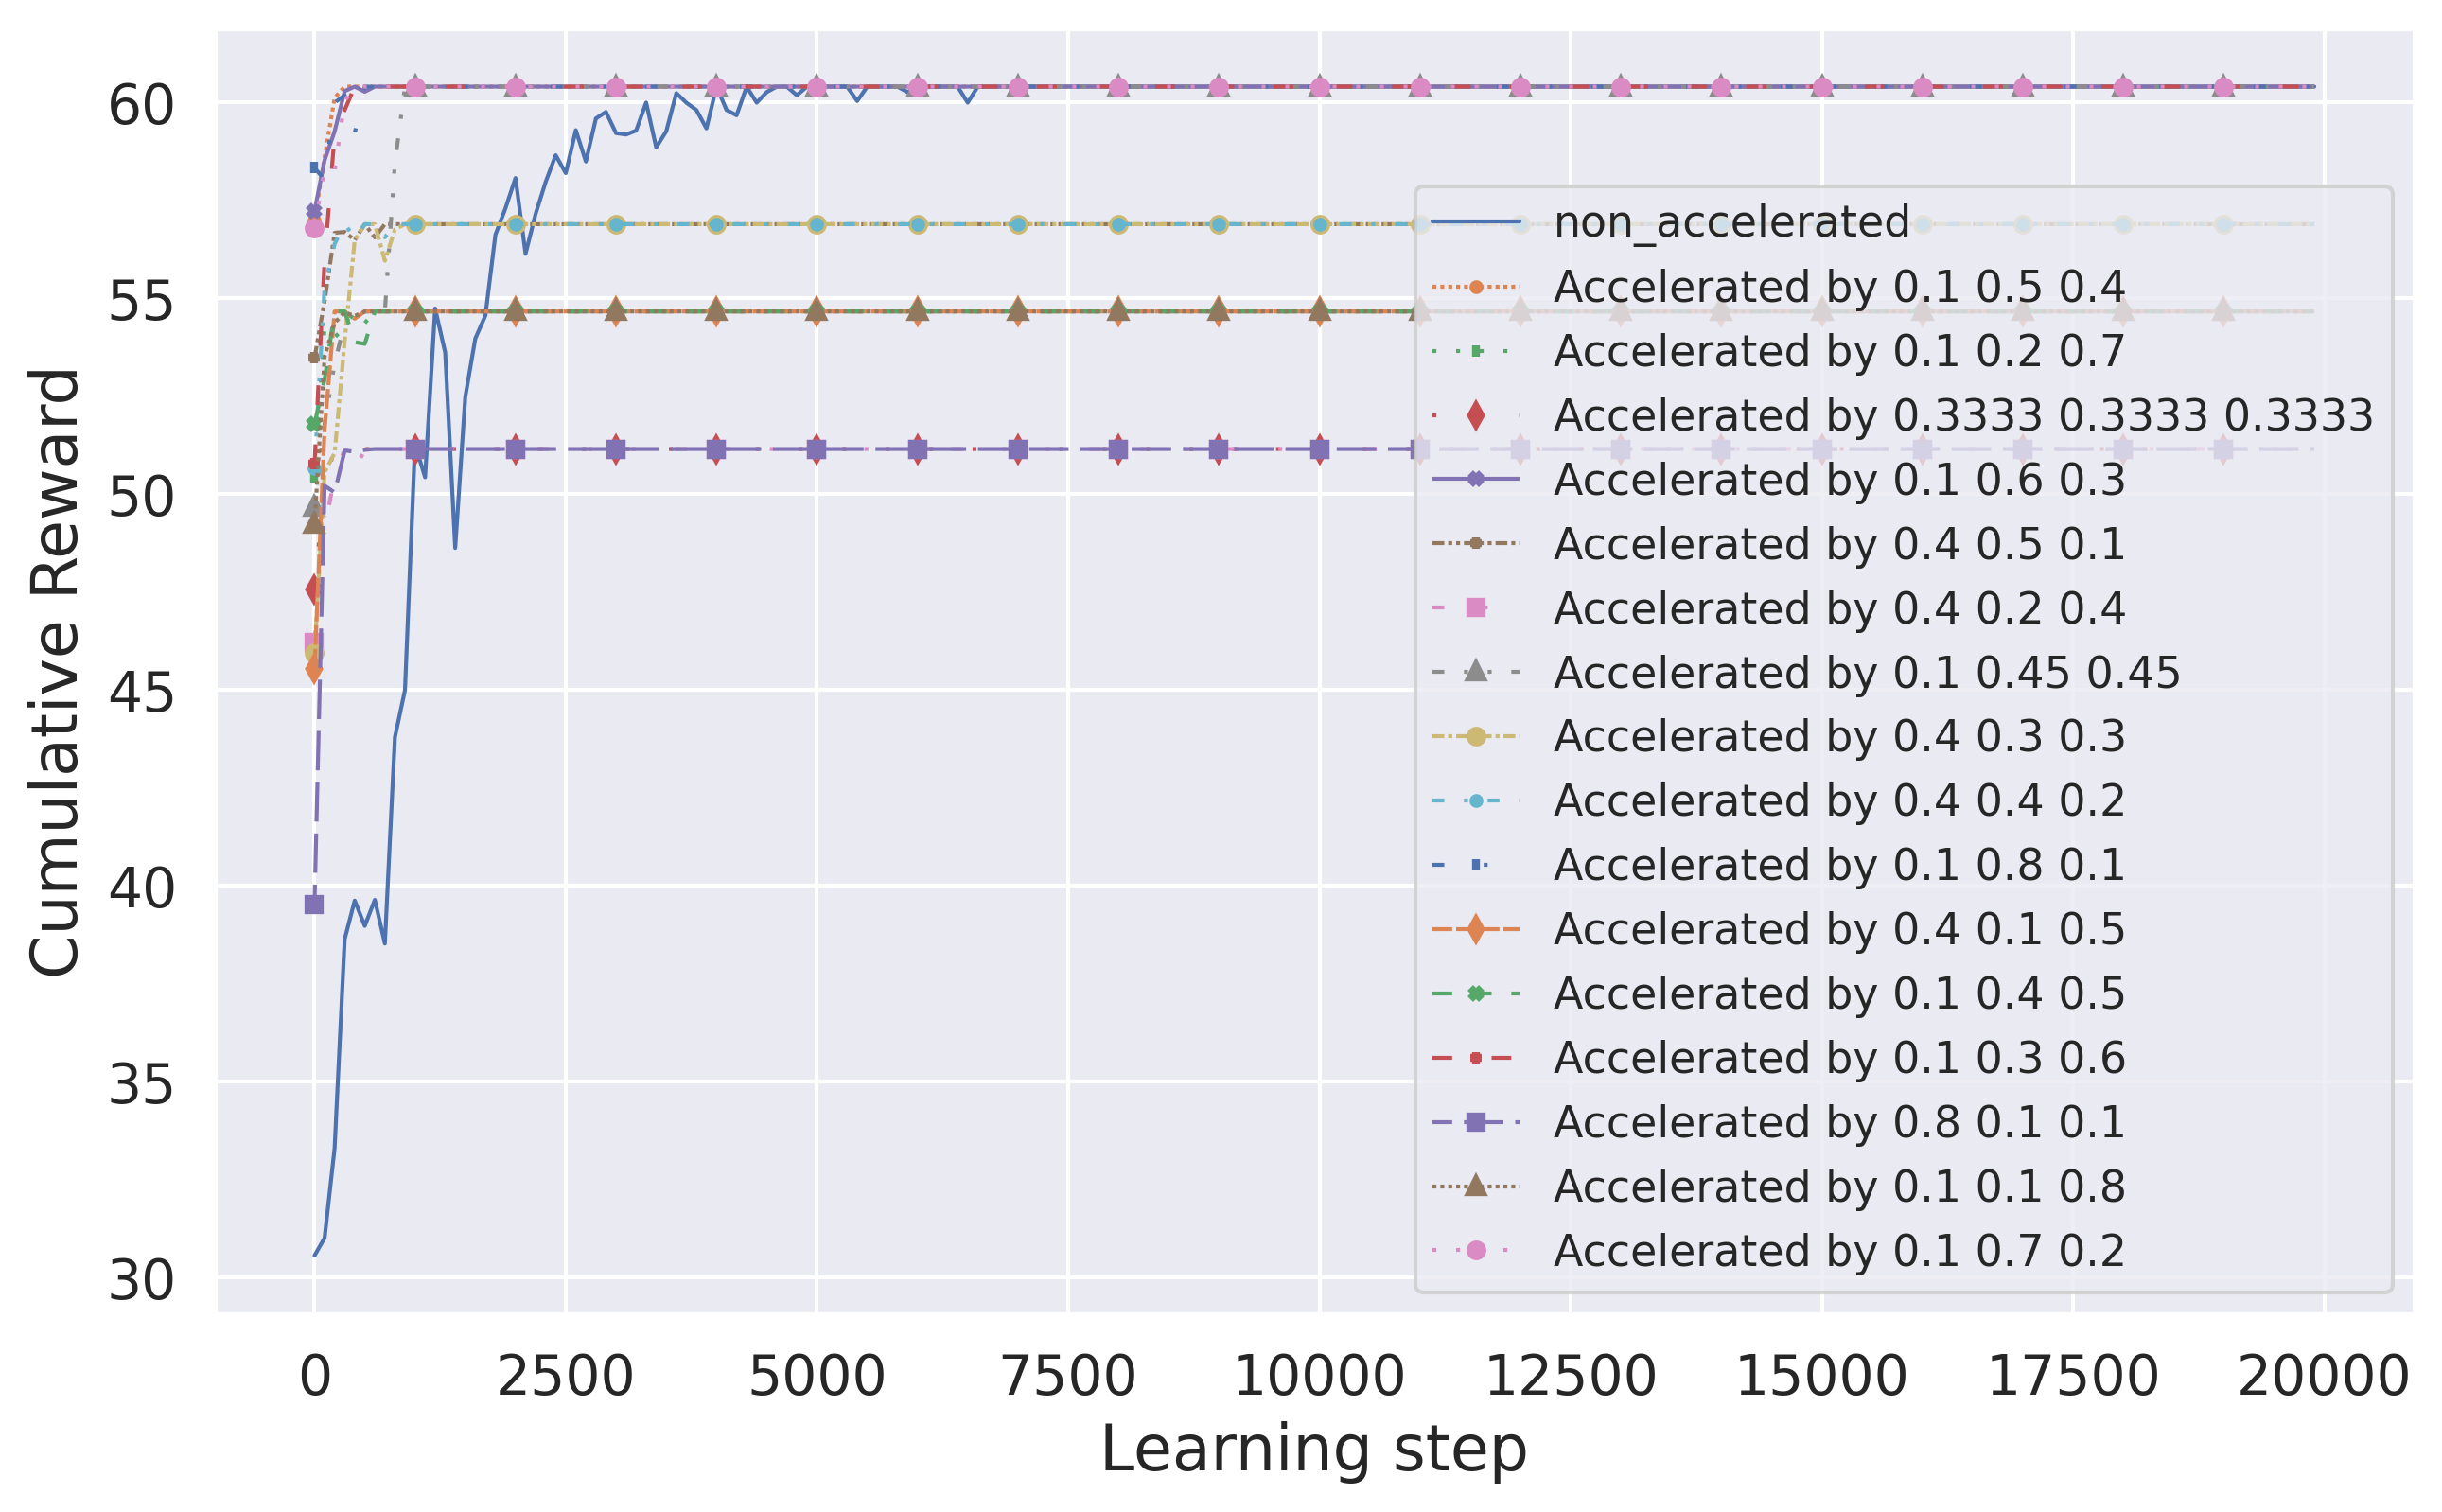

In [82]:
# Using Numpy to create an array X
X = np.arange(0, 200, 1)*100

for weight_comb in all_data_dict['newly_introduced']:
    temp_string = str(all_data_dict['newly_introduced'][weight_comb][model]['config']['generic']['w_volte']) + ' ' +\
    str(all_data_dict['newly_introduced'][weight_comb][model]['config']['generic']['w_urllc']) + ' ' +\
    str(all_data_dict['newly_introduced'][weight_comb][model]['config']['generic']['w_video'])

    if (temp_string != '0.1 0.55 0.35' ) and (temp_string != '0.15 0.8 0.05') and (temp_string != '0.25 0.7 0.05')\
    and (temp_string != '0.5 0.4 0.1'):
        continue
    
    figure(figsize=(10, 6), dpi=300)
    ax = plt.subplot(111)

    markers = ["o" , "^" , "s", "+", "x", "d", "|", '.',"o" , "^" , "s", "+", "x", "d", "|", '.']

    from collections import OrderedDict

    linestyles_dict = OrderedDict(
        [('solid',               (0, ())),
         ('loosely dotted',      (0, (1, 10))),
         ('dotted',              (0, (1, 5))),
         ('densely dotted',      (0, (1, 1))),

         ('loosely dashed',      (0, (5, 10))),
         ('dashed',              (0, (5, 5))),
         ('densely dashed',      (0, (5, 1))),
         ('long dash with offset', (5, (10, 3))),
         ('loosely dashdotted',  (0, (3, 10, 1, 10))),
         ('dashdotted',          (0, (3, 5, 1, 5))),
         ('densely dashdotted',  (0, (3, 1, 1, 1))),

         ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
         ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
         ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))])

    linestyles = ['solid', 'loosely dotted', 'dotted', 'densely dotted', 'long dash with offset', 'loosely dashed', 'dashed', 'densely dashed', 'loosely dashdotted', 'dashdotted','densely dashdotted', 'dashdotdotted','loosely dashdotdotted', 'densely dashdotdotted', 'solid', 'loosely dotted', 'dotted', 'densely dotted']
    
    for model in all_data_dict['newly_introduced'][weight_comb]:
        

        if model=='non_accelerated':
            ax.plot(X, all_data_dict['newly_introduced'][weight_comb][model]['rewards']['episodes'],\
                 label= model, linewidth=1)
        else:
            ax.plot(X, all_data_dict['newly_introduced'][weight_comb][model]['rewards']['episodes'],\
                 ls=linestyles_dict[linestyles.pop()], marker=markers.pop(), markersize=3, markevery=10, markeredgewidth=2, linewidth=1, label= 'Accelerated by '+ \
                     str(all_data_dict['newly_introduced'][weight_comb][model]['config']['generic']['by_w_volte']) + ' ' +\
              str(all_data_dict['newly_introduced'][weight_comb][model]['config']['generic']['by_w_urllc']) + ' ' +\
              str(all_data_dict['newly_introduced'][weight_comb][model]['config']['generic']['by_w_video']))
    
    # Naming the x-axis, y-axis and the whole graph
    plt.xlabel("Learning step", fontsize=16)
    plt.ylabel("Cumulative Reward", fontsize=16)

    print('Communlative Reward over 100 learning steps ' + \
              str(all_data_dict['newly_introduced'][weight_comb][model]['config']['generic']['w_volte']) + ' ' +\
              str(all_data_dict['newly_introduced'][weight_comb][model]['config']['generic']['w_urllc']) + ' ' +\
              str(all_data_dict['newly_introduced'][weight_comb][model]['config']['generic']['w_video']))

    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14)
    
    # Adding legend
    ax.legend()

    if (temp_string == '0.1 0.55 0.35'):
        plt.savefig('fig4-a.png', dpi=300, bbox_inches='tight')
    elif (temp_string == '0.15 0.8 0.05'):
        plt.savefig('fig4-b.png', dpi=300, bbox_inches='tight')
    elif (temp_string == '0.25 0.7 0.05'):
        plt.savefig('fig4-c.png', dpi=300, bbox_inches='tight')
    elif (temp_string == '0.5 0.4 0.1'):
        plt.savefig('fig4-d.png', dpi=300, bbox_inches='tight')
    
    # To load the display window
    plt.show()

In [65]:
improvement_dict = {}
for weight_comb in all_data_dict['newly_introduced']:
    improvement_dict[weight_comb] =  {}
    for model in all_data_dict['newly_introduced'][weight_comb]:
        improvement_dict[weight_comb][model] = {}
        temp_reward_list = all_data_dict['newly_introduced'][weight_comb][model]['rewards']['episodes'].copy()
        if ( (model=='non_accelerated') and ('max_val' not in improvement_dict[weight_comb]['non_accelerated'])):
            max_value = temp_reward_list[-1]
        else:
            max_value = max(temp_reward_list)
        A = np.array(temp_reward_list)
        maximum_indices = np.where(A==max_value)
        maximum_indices[0].tolist()
        for index in maximum_indices[0]:
            temp_list = [max_value] * len(temp_reward_list[index:])
            if temp_list == temp_reward_list[index:]:
                improvement_dict[weight_comb][model]['max_val'] = max_value
                improvement_dict[weight_comb][model]['conv_step'] = index
                break

In [66]:
improv_stats = {}
per_model_stats = {}
for weight_comb in improvement_dict:
    improv_stats[weight_comb] = {}
    improv_stats[weight_comb]['improv_steps'] = []
    improv_stats[weight_comb]['converged_models_count'] = 0
    for model in improvement_dict[weight_comb]:
        if (model not in per_model_stats) and (model != 'non_accelerated'):
            per_model_stats[model] = {}
            per_model_stats[model]['improv_steps'] = []
            per_model_stats[model]['converged_models_count'] = 0
        if (model != 'non_accelerated') and ('max_val' in improvement_dict[weight_comb][model]):
            if (improvement_dict[weight_comb][model]["max_val"] \
                >= improvement_dict[weight_comb]['non_accelerated']["max_val"]) \
            and (improvement_dict[weight_comb][model]["conv_step"] \
                < improvement_dict[weight_comb]['non_accelerated']["conv_step"]):
                improv_steps = improvement_dict[weight_comb]['non_accelerated']["conv_step"] \
                - improvement_dict[weight_comb][model]["conv_step"]
                improv_stats[weight_comb]['improv_steps'].append(improv_steps*100)
                improv_stats[weight_comb]['converged_models_count'] += 1
                per_model_stats[model]['improv_steps'].append(improv_steps*100)
                per_model_stats[model]['converged_models_count'] += 1

In [67]:
big_improv_steps = []
big_converged_models_count = []
for weight_comb in improv_stats:
    big_improv_steps.extend(improv_stats[weight_comb]['improv_steps'])
    big_converged_models_count.append(improv_stats[weight_comb]['converged_models_count'])

In [68]:
min(big_improv_steps)

4500

In [69]:
max(big_improv_steps)

14000

In [70]:
mean(big_improv_steps)

7377.631578947368

In [71]:
median(big_improv_steps)

6900.0

In [72]:
min(big_converged_models_count)

1

In [73]:
max(big_converged_models_count)

16

In [74]:
mean(big_converged_models_count)

7.169811320754717

In [75]:
median(big_converged_models_count)

7.0

In [76]:
for model in per_model_stats:
    per_model_stats[model]['max_improv_steps'] = max(per_model_stats[model]['improv_steps'])
    per_model_stats[model]['min_improv_steps'] = min(per_model_stats[model]['improv_steps'])
    per_model_stats[model]['mean_improv_steps'] = mean(per_model_stats[model]['improv_steps'])
    per_model_stats[model]['median_improv_steps'] = median(per_model_stats[model]['improv_steps'])

In [77]:
big_per_model_improv_steps = []
big_per_model_converged_models_count = []
for model in per_model_stats:
    big_per_model_improv_steps.extend(per_model_stats[model]['improv_steps'])
    big_per_model_converged_models_count.append(per_model_stats[model]['converged_models_count'])
    per_model_stats[model]['max_improv_steps'] = max(per_model_stats[model]['improv_steps'])
    per_model_stats[model]['min_improv_steps'] = min(per_model_stats[model]['improv_steps'])
    per_model_stats[model]['mean_improv_steps'] = mean(per_model_stats[model]['improv_steps'])
    per_model_stats[model]['median_improv_steps'] = median(per_model_stats[model]['improv_steps'])

In [78]:
min(big_per_model_converged_models_count)

24

In [79]:
max(big_per_model_converged_models_count)

76

In [80]:
mean(big_per_model_converged_models_count)

47.5

In [81]:
median(big_per_model_converged_models_count)

49.5